# XGBoost with SMOTE

Our EDA of the data showed that there were very few training examples of the 'functional needs repair' label (around 5%) so we used SMOTE to generate additional examples of the imbalanced class, and make the dataset a little more evenly balanced. This allows our model to better pick up on the intricacies of the minority classes of the dataset.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#read in csv's and merge
values_df = pd.read_csv('train_set_values.csv')
labels_df = pd.read_csv('train_set_labels.csv')
test_df = pd.read_csv('test_set_values.csv')

df= pd.merge(values_df, labels_df, on = 'id' )

df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [2]:
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [3]:
from imblearn.over_sampling import SMOTE
from preprocessor import DataCleaner
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.classifier import StackingCVClassifier

The cleanup process is encapsulated in a separate file called preprocessor.py. The DataCleanup function allows us to go through the whole process at once and returns two dataframes, one for the training data and one for the test data.

In [4]:
train, test = DataCleaner(values_df, labels_df, test_df)

In [5]:
train['status_group'].value_counts()

2    32259
0    22824
1     4317
Name: status_group, dtype: int64

We assign the appropriate columns in the dataframe to features(X) and targets(y), and then do a train test split on the data.

In [6]:
y = train['status_group']
X = train.drop(columns = 'status_group')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

SMOTE is then used to rebalance the data in favour of the minority classes in the data. This is done on both the whole dataset and also on the train split.

In [7]:
smote = SMOTE(sampling_strategy = 'auto', n_jobs = -1)
X_resampled, y_resampled = smote.fit_sample(X, y)
print(y.value_counts())
print(y_resampled.value_counts())

2    32259
0    22824
1     4317
Name: status_group, dtype: int64
2    32259
1    32259
0    32259
Name: status_group, dtype: int64


In [8]:
smote_train = SMOTE(sampling_strategy = 'auto', n_jobs = -1)
X_train_resampled, y_train_resampled = smote_train.fit_sample(X_train, y_train)
print(y_train.value_counts())
print(y_train_resampled.value_counts())

2    24161
0    17146
1     3243
Name: status_group, dtype: int64
2    24161
1    24161
0    24161
Name: status_group, dtype: int64


An XGBoost classifier is evaluated for performance with the above dataset. The parameters are set for it to be a ternary tree based classifier, with a tree depth of 16 levels.

In [10]:
clf_xg = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 16, colsample_bytree = .4, n_jobs = -1)
scores = cross_val_score(clf_xg, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print(scores.mean(), '+/-', scores.std())

0.8447505552644599 +/- 0.07399327431795621


The model is then trained and predictions are made on multiple datasets. The corresponding confusion matrices are also plotted to visualize the predictions

In [11]:
clf_xg.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eta=0.1,
              eval_metric='merror', gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=16, maximize=False,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nrounds='min.error.idx', nthread=None, num_class=3,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [12]:
preds_train_resampled = clf_xg.predict(X_train_resampled)
preds_train = clf_xg.predict(X_train)
preds_test = clf_xg.predict(X_test)

Accuracy Score:  0.9644054467944208


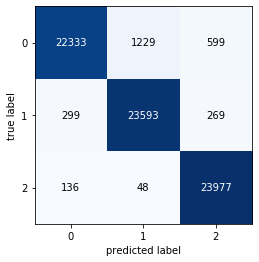

In [13]:
print("Accuracy Score: ", accuracy_score(y_train_resampled, preds_train_resampled))
cm = confusion_matrix(y_train_resampled, preds_train_resampled)
plot_confusion_matrix(cm)
plt.show()

Accuracy Score:  0.9754882154882155


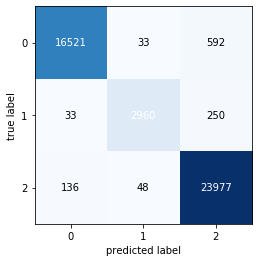

In [14]:
print("Accuracy Score: ", accuracy_score(y_train, preds_train))
cm = confusion_matrix(y_train, preds_train)
plot_confusion_matrix(cm)
plt.show()

Accuracy Score:  0.9745454545454545


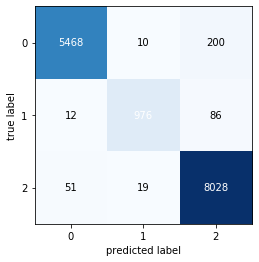

In [15]:
print("Accuracy Score: ", accuracy_score(y_test, preds_test))
cm = confusion_matrix(y_test, preds_test)
plot_confusion_matrix(cm)
plt.show()

# Submission 

Predictions are made on the test data and a csv is generated for submission.

In [16]:
preds_main_test = clf_xg.predict(test)
submission_preds = pd.Series(preds_main_test)

In [17]:
submission_preds.value_counts()

2    8909
0    5336
1     605
dtype: int64

In [21]:
submission_preds_mapped = submission_preds.map({2: 'functional', 1: 'functional needs repair', 0: 'non functional'})
submission_preds_mapped.value_counts()

functional                 8909
non functional             5336
functional needs repair     605
dtype: int64

In [22]:
submit_df = pd.concat([test_df['id'], submission_preds_mapped], axis = 1)
submit_df.rename(columns = {0: 'status_group'}, inplace = True)
submit_df.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [23]:
submit_df.to_csv('submission.csv', index = False)